In [17]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd

In [18]:


sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333

k_g = 0.16
k_r = 0.08
k_i = 0.02
k_z = 0.01

PG_RA = 201.4144438
PG_DEC = -8.8219767

RA_SA100_241 = 133.14186958
DEC_SA100_241 = -0.66360306

RA_SA101_315 = 148.71371625  
DEC_SA101_315 = -0.45861306

g_SA100_241 = 10.166
r_SA100_241 = 10.229
i_SA100_241 = 10.347
z_SA100_241 = 10.456

g_SA101_315 = 11.703
r_SA101_315 = 10.862
i_SA101_315 = 10.560
z_SA101_315 = 10.416


In [19]:
NGC3783_g = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/g-NGC3783/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/g-NGC3783/')]

SA100_241_g = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/g-SA100_241/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/g-SA100_241/')]

SA101_315_g = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/g-SA101_315/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/g-SA101_315/')]

In [20]:
NGC3783_r = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/r-NGC3783/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/r-NGC3783/')]

SA100_241_r = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/r-SA100_241/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/r-SA100_241/')]

SA101_315_r = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/r-SA101_315/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/r-SA101_315/')]

In [21]:
NGC3783_i = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/i-NGC3783/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/i-NGC3783/')]

SA100_241_i = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/i-SA100_241/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/i-SA100_241/')]

SA101_315_i = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/i-SA101_315/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/i-SA101_315/')]

In [22]:
NGC3783_z = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/z-NGC3783/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/z-NGC3783/')]

SA100_241_z = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/z-SA100_241/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/z-SA100_241/')]

SA101_315_z = [os.path.join('/../home/lynge/MasterP/NGC3783-cal/21-04-17/z-SA101_315/',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783-cal/21-04-17/z-SA101_315/')]

In [23]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [24]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [25]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [26]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    try:
        mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
        AGNdata[mask] = float(0)
        mask = AGNdata == 0.
        rows = np.flatnonzero((~mask).sum(axis=1))
        cols = np.flatnonzero((~mask).sum(axis=0))
        AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
        #print apparature/float(pixspa)
    except:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata/float(exptime), x1, y1


In [27]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [28]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1/10.
    data2_2 = data2/10.
    return SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

aperture1 = 0.001
aperture2 = 0.002
date = []
flucompsta1 = []
flucompsta2 = []
flucompsta3 = []
flucompsta4 = []
flucompsta5 = []
flucompsta6 = []
flucompsta7 = []
flucompsta1_1 = []
flucompsta2_1 = []
flucompsta3_1 = []
flucompsta4_1 = []
flucompsta5_1 = []
flucompsta6_1 = []
flucompsta7_1 = []
SNR1 = []
SNR2 = []
SNR3 = []
SNR4 = []
SNR5 = []
SNR1_1 = []
SNR2_1 = []
SNR3_1 = []
SNR4_1 = []
SNR5_1 = []
SNR_comp = []

for i in range(len(quas)):
    #print 'Frame nr. ', i
    header = pyfits.getheader(quas[i])
    a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]
    a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]
    a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]
    a4 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta3_RA_WORLD,sta3_DEC_WORLD),aperture1)[0]
    a5 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (gal_RA_WORLD,gal_DEC_WORLD),aperture1)[0]
    a1_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (qua1_RA_WORLD,qua1_DEC_WORLD),aperture2)[0]
    a2_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta1_RA_WORLD,sta1_DEC_WORLD),aperture2)[0]
    a3_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta2_RA_WORLD,sta2_DEC_WORLD),aperture2)[0]
    a4_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta3_RA_WORLD,sta3_DEC_WORLD),aperture2)[0]
    a5_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (gal_RA_WORLD,gal_DEC_WORLD),aperture2)[0]
    a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]
    date.append(header['MJD-OBS'])
    flucompsta1.append(comp1(np.sum(a1),np.sum(a2)))
    flucompsta2.append(comp1(np.sum(a1),np.sum(a3)))
    flucompsta3.append(comp1(np.sum(a3),np.sum(a2)))
    flucompsta4.append(comp1(np.sum(a1),np.sum(a4)))
    flucompsta5.append(comp1(np.sum(a1),np.sum(a5)))
    flucompsta6.append(comp1(np.sum(a4),np.sum(a2)))
    flucompsta7.append(comp1(np.sum(a5),np.sum(a2)))
    flucompsta1_1.append(comp1(np.sum(a1_1),np.sum(a2_1)))
    flucompsta2_1.append(comp1(np.sum(a1_1),np.sum(a3_1)))
    flucompsta3_1.append(comp1(np.sum(a3_1),np.sum(a2_1)))
    flucompsta4_1.append(comp1(np.sum(a1_1),np.sum(a4_1)))
    flucompsta5_1.append(comp1(np.sum(a1_1),np.sum(a5_1)))
    flucompsta6_1.append(comp1(np.sum(a4_1),np.sum(a2_1)))
    flucompsta7_1.append(comp1(np.sum(a5_1),np.sum(a2_1)))
    SNR1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture1,aperture1))
    SNR2.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture1,aperture1))
    SNR3.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture1,aperture1))
    SNR4.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture1,aperture1))
    SNR5.append(SNR(np.sum(a5),np.sum(a_sky),header,aperture1,aperture1))
    SNR1_1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture2,aperture2))
    SNR2_1.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture2,aperture2))
    SNR3_1.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture2,aperture2))
    SNR4_1.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture2,aperture2))
    SNR5_1.append(SNR(np.sum(a5),np.sum(a_sky),header,aperture2,aperture2))
print SNR1
print len(quas)

In [41]:
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000

def findmag(start,compare1,RA_star,DEC_star,RA_com,DEC_com,mag_com,AIR_EXTINCTION):
    aperture1 = 0.002
    #201.5441,-8.8601
    com_flu = []
    com_AIRMASS = []
    com_EXPTIME = []
    star_flu = []
    star_AIRMASS = []
    star_EXPTIME = []
    for i in range(len(compare1)):
        print 'Frame nr. ', i
        header = pyfits.getheader(compare1[i])
        a1 = curve(pyfits.getdata(compare1[i]),pyfits.getheader(compare1[i]),WCS(compare1[i]),
                   (RA_com,DEC_com),aperture1)[0]
        com_flu.append(np.sum(a1)), com_AIRMASS.append(header['AIRMASS']), com_EXPTIME.append(header['EXPTIME'])
        #plt.figure(figsize=(3,3))
        #plt.imshow(a1,cmap='hot')
        #plt.colorbar()
    for i in range(len(start)):
        print 'Frame nr. ', i, 
        header = pyfits.getheader(start[i])
        a1 = curve(pyfits.getdata(start[i]),pyfits.getheader(start[i]),WCS(start[i]),
                   (RA_star,DEC_star),aperture1)[0]
        star_flu.append(np.sum(a1)), star_AIRMASS.append(header['AIRMASS']), star_EXPTIME.append(header['EXPTIME'])
        #plt.figure(figsize=(3,3))
        #plt.imshow(a1,cmap='hot')
        #plt.colorbar()
    com_flu = np.array(com_flu)
    com_AIRMASS = np.array(com_AIRMASS)
    com_EXPTIME = np.array(com_EXPTIME)
    star_flu = np.array(star_flu)
    star_AIRMASS = np.array(star_AIRMASS)
    star_EXPTIME = np.array(star_EXPTIME)
    com_flu = com_flu/com_EXPTIME
    star_flu = star_flu/star_EXPTIME
    com_flux = np.mean(com_flu)
    com_AIRMASS_num = np.mean(com_AIRMASS)
    star_AIRMASS_num = np.mean(star_AIRMASS)
    mag = -(AIR_EXTINCTION)*(star_AIRMASS_num-com_AIRMASS_num) + mag_com - 2.5*np.log10(star_flu/float(com_flux))
    print mag
    return mag

Frame nr.  0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame n

 Frame nr.  1 Frame nr.  2INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs

Frame nr.  0INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame n

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 Frame nr.  2INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 [ 12.4

Frame nr.  0INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame n

Frame nr.  0INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame n

Frame nr.  0INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame n

Frame nr.  0INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame n

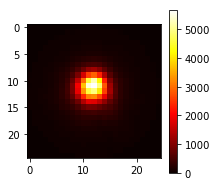

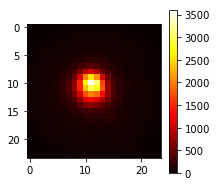

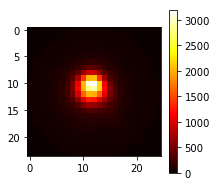

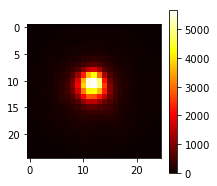

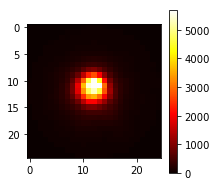

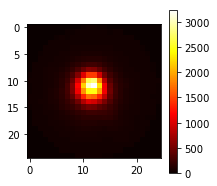

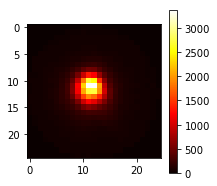

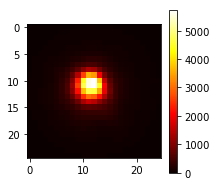

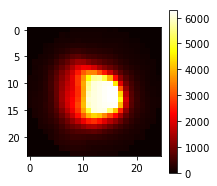

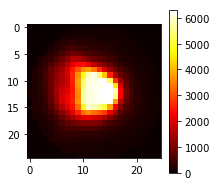

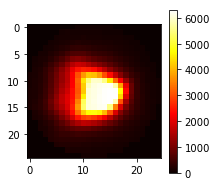

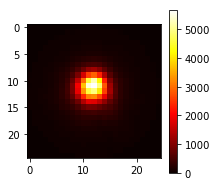

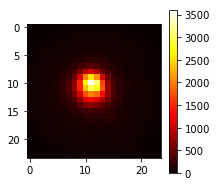

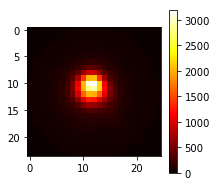

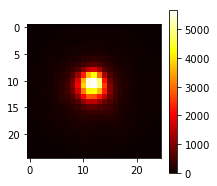

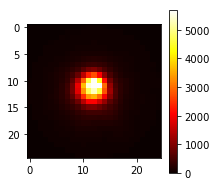

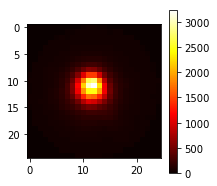

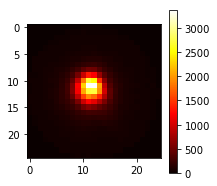

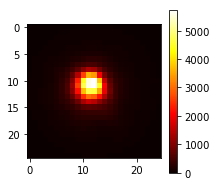

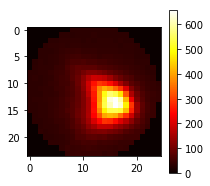

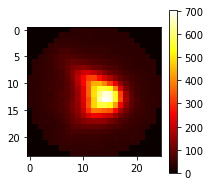

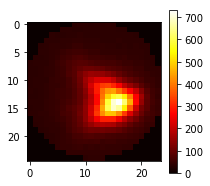

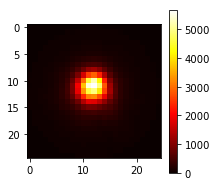

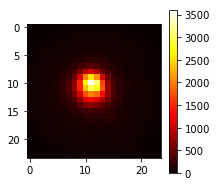

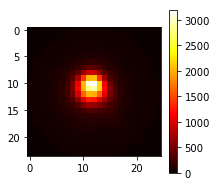

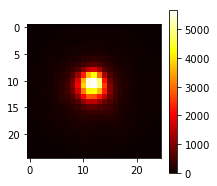

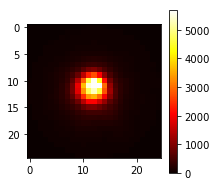

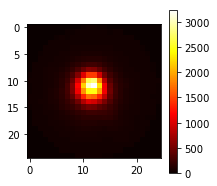

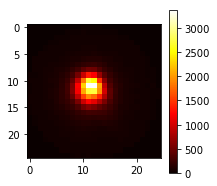

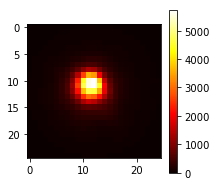

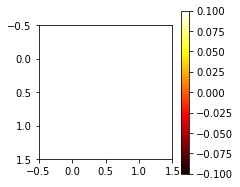

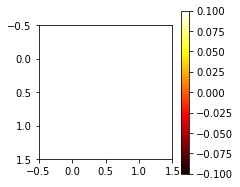

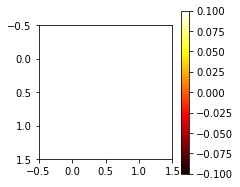

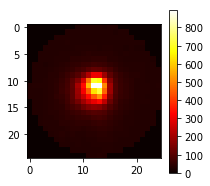

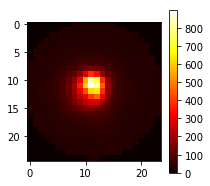

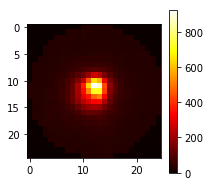

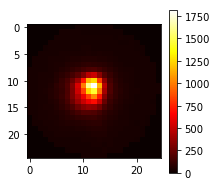

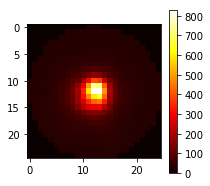

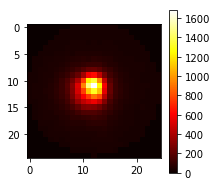

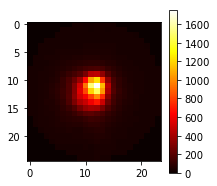

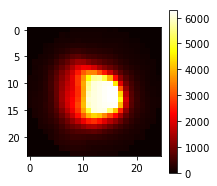

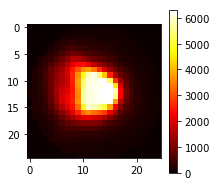

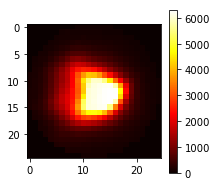

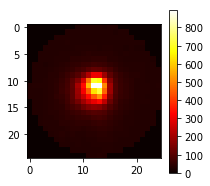

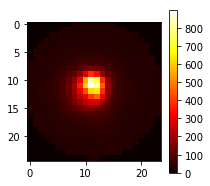

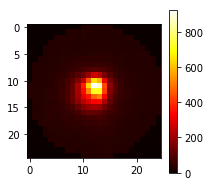

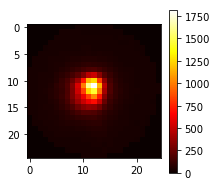

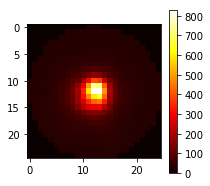

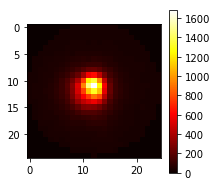

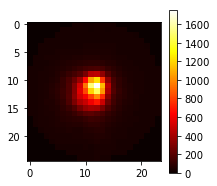

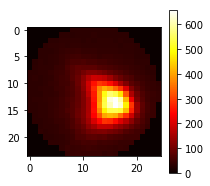

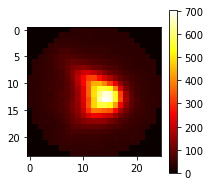

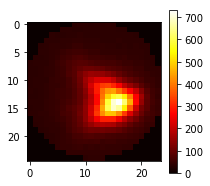

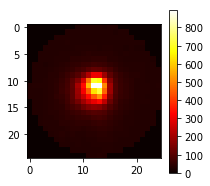

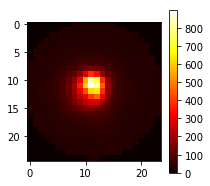

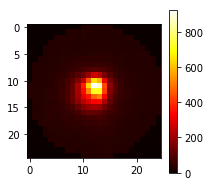

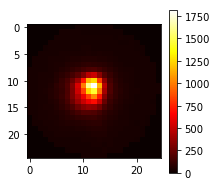

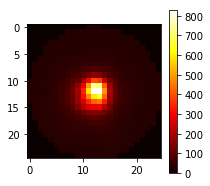

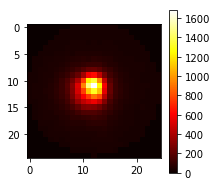

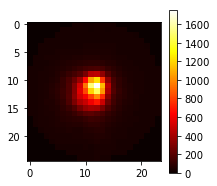

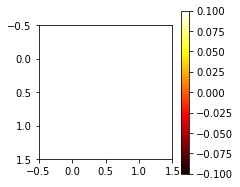

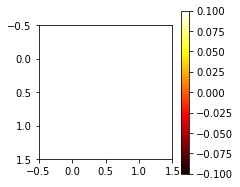

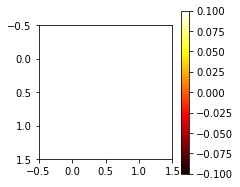

In [39]:
HD101274_1 = findmag(NGC3783_g,SA100_241_g,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA100_241,DEC_SA100_241,z_SA100_241,k_g)
Tyc_22_1 = findmag(NGC3783_g,SA100_241_g,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA100_241,DEC_SA100_241,z_SA100_241,k_g)
Tyc_529_1 = findmag(NGC3783_g,SA100_241_g,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA100_241,DEC_SA100_241,z_SA100_241,k_g)

HD101274_2 = findmag(NGC3783_g,SA101_315_g,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA101_315,DEC_SA101_315,z_SA101_315,k_g)
Tyc_22_2 = findmag(NGC3783_g,SA101_315_g,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA101_315,DEC_SA101_315,z_SA101_315,k_g)
Tyc_529_2 = findmag(NGC3783_g,SA101_315_g,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA101_315,DEC_SA101_315,z_SA101_315,k_g)





In [54]:
print 'g-filter'
print HD101274_1
print HD101274_2
print np.mean((HD101274_1,HD101274_2)), np.std((HD101274_1,HD101274_2))

print Tyc_22_1
print Tyc_22_2
print np.mean((Tyc_22_1,Tyc_22_2)), np.std((Tyc_22_1,Tyc_22_2))

print Tyc_529_1
print Tyc_529_2
print np.mean((Tyc_529_1,Tyc_529_2)), np.std((Tyc_529_1,Tyc_529_2))

g-filter
[ 9.72462582  9.72871577  9.69945463]
[ 8.51414604  8.51823599  8.48897485]
9.1123588512 0.605378159364
[ 12.40701453  12.39867253  12.37773414]
[ 11.19653476  11.18819275  11.16725436]
11.7892338463 0.605365202776
[ nan  nan  nan]
[ nan  nan  nan]
nan nan


In [55]:
HD101274_1 = findmag(NGC3783_r,SA100_241_r,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA100_241,DEC_SA100_241,z_SA100_241,k_r)
Tyc_22_1 = findmag(NGC3783_r,SA100_241_r,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA100_241,DEC_SA100_241,z_SA100_241,k_r)
Tyc_529_1 = findmag(NGC3783_r,SA100_241_r,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA100_241,DEC_SA100_241,z_SA100_241,k_r)

HD101274_2 = findmag(NGC3783_r,SA101_315_r,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA101_315,DEC_SA101_315,z_SA101_315,k_r)
Tyc_22_2 = findmag(NGC3783_r,SA101_315_r,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA101_315,DEC_SA101_315,z_SA101_315,k_r)
Tyc_529_2 = findmag(NGC3783_r,SA101_315_r,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA101_315,DEC_SA101_315,z_SA101_315,k_r)



Frame nr.  0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame n

 Frame nr.  2INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 [ 9.81

 Frame nr.  2INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 [ 11.9

 Frame nr.  2INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 [ nan 

 Frame nr.  2INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 [ 9.24

Frame nr.  0INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame n

Frame nr.  7
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame n

In [56]:
print 'r-filter'
print HD101274_1
print HD101274_2
print np.mean((HD101274_1,HD101274_2)), np.std((HD101274_1,HD101274_2))

print Tyc_22_1
print Tyc_22_2
print np.mean((Tyc_22_1,Tyc_22_2)), np.std((Tyc_22_1,Tyc_22_2))

print Tyc_529_1
print Tyc_529_2
print np.mean((Tyc_529_1,Tyc_529_2)), np.std((Tyc_529_1,Tyc_529_2))

r-filter
[ 9.81329425  9.79874636  9.77798306]
[ 9.24195812  9.22741023  9.20664693]
9.51100649324 0.286035316982
[ 11.93177356  11.9282972   11.93034856]
[ 11.36043743  11.35696107  11.35901243]
11.6444717081 0.285671627973
[ nan  nan  nan]
[ nan  nan  nan]
nan nan


In [57]:
HD101274_1 = findmag(NGC3783_i,SA100_241_i,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA100_241,DEC_SA100_241,z_SA100_241,k_i)
Tyc_22_1 = findmag(NGC3783_i,SA100_241_i,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA100_241,DEC_SA100_241,z_SA100_241,k_i)
Tyc_529_1 = findmag(NGC3783_i,SA100_241_i,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA100_241,DEC_SA100_241,z_SA100_241,k_i)

HD101274_2 = findmag(NGC3783_i,SA101_315_i,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA101_315,DEC_SA101_315,z_SA101_315,k_i)
Tyc_22_2 = findmag(NGC3783_i,SA101_315_i,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA101_315,DEC_SA101_315,z_SA101_315,k_i)
Tyc_529_2 = findmag(NGC3783_i,SA101_315_i,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA101_315,DEC_SA101_315,z_SA101_315,k_i)



Frame nr.  0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame n

NoConvergence: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 2 iterations, the solution is diverging at least for one input point.

In [58]:
print 'i-filter'
print HD101274_1
print HD101274_2
print np.mean((HD101274_1,HD101274_2)), np.std((HD101274_1,HD101274_2))

print Tyc_22_1
print Tyc_22_2
print np.mean((Tyc_22_1,Tyc_22_2)), np.std((Tyc_22_1,Tyc_22_2))

print Tyc_529_1
print Tyc_529_2
print np.mean((Tyc_529_1,Tyc_529_2)), np.std((Tyc_529_1,Tyc_529_2))

i-filter
[ 9.81329425  9.79874636  9.77798306]
[ 9.24195812  9.22741023  9.20664693]
9.51100649324 0.286035316982
[ 11.93177356  11.9282972   11.93034856]
[ 11.36043743  11.35696107  11.35901243]
11.6444717081 0.285671627973
[ nan  nan  nan]
[ nan  nan  nan]
nan nan


In [59]:
HD101274_1 = findmag(NGC3783_z,SA100_241_z,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA100_241,DEC_SA100_241,z_SA100_241,k_z)
Tyc_22_1 = findmag(NGC3783_z,SA100_241_z,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA100_241,DEC_SA100_241,z_SA100_241,k_z)
Tyc_529_1 = findmag(NGC3783_z,SA100_241_z,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA100_241,DEC_SA100_241,z_SA100_241,k_z)

HD101274_2 = findmag(NGC3783_z,SA101_315_z,sta1_RA_WORLD,sta1_DEC_WORLD,\
                     RA_SA101_315,DEC_SA101_315,z_SA101_315,k_z)
Tyc_22_2 = findmag(NGC3783_z,SA101_315_z,sta2_RA_WORLD,sta2_DEC_WORLD,\
                   RA_SA101_315,DEC_SA101_315,z_SA101_315,k_z)
Tyc_529_2 = findmag(NGC3783_z,SA101_315_z,sta3_RA_WORLD,sta3_DEC_WORLD,\
                    RA_SA101_315,DEC_SA101_315,z_SA101_315,k_z)



Frame nr.  0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame n

 Frame nr.  1INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame 

Frame nr.  0INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
 Frame n

Frame nr.  7
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame n

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame nr.  7
INFO: 


Frame nr.  6
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame n

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Frame nr.  6
INFO: 


In [60]:
print 'z-filter'
print HD101274_1
print HD101274_2
print np.mean((HD101274_1,HD101274_2)), np.std((HD101274_1,HD101274_2))

print Tyc_22_1
print Tyc_22_2
print np.mean((Tyc_22_1,Tyc_22_2)), np.std((Tyc_22_1,Tyc_22_2))

print Tyc_529_1
print Tyc_529_2
print np.mean((Tyc_529_1,Tyc_529_2)), np.std((Tyc_529_1,Tyc_529_2))

z-filter
[ 10.31807146  10.3249512   10.31659041]
[ 10.29277596  10.2996557   10.2912949 ]
10.3072232731 0.0131618889793
[ 11.54046353  11.52784374  11.53038865]
[ 11.51516803  11.50254824  11.50509314]
11.5202508874 0.0137716676292
[ nan  nan  nan]
[ nan  nan  nan]
nan nan
